# 1. Comando Iniciais

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.1. Importando Bibliotecas

In [2]:
!pip install mlxtend --upgrade --no-deps # Versão do Mlxtend: 0.19.0

     |████████████████████████████████| 1.3 MB 4.3 MB/s 
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [22]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import  ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import CategoricalAccuracy, AUC, Precision, Recall
from tensorflow import keras

import sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, precision_score, recall_score

import mlxtend
from mlxtend.plotting import plot_confusion_matrix

import itertools
import os
from os import walk
import re

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Utility Script - Criados dentro do Kaggle Code, devido ao fato que são modulo customizados 
%cd /content/drive/MyDrive/TCC-Melo/Kaggle/
from lrfinder import *
from cyclicallr import * 

/content/drive/MyDrive/TCC-Melo/Kaggle


### 1.1.1. Demostrando versões das bibliotecas

In [5]:
print(f'Versão do Numpy: {np.__version__}')
print(f'Versão do Pandas: {pd.__version__}')
print(f'Versão do Matplotlib: {mpl.__version__}')
print(f'Versão do TensorFlow: {tf.__version__}')
print(f'Versão do Keras: {keras.__version__}')
print(f'Versão do Sklearn: {sklearn.__version__}')
print(f'Versão do Mlxtend: {mlxtend.__version__}')

Versão do Numpy: 1.19.5
Versão do Pandas: 1.1.5
Versão do Matplotlib: 3.2.2
Versão do TensorFlow: 2.6.0
Versão do Keras: 2.6.0
Versão do Sklearn: 0.22.2.post1
Versão do Mlxtend: 0.19.0


## 1.2. Verificando Accelerator

In [6]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Oct 24 23:34:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)
tf.test.is_gpu_available()

Name: /physical_device:GPU:0   Type: GPU
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

## 1.3. Variaveis Globais 

In [8]:
# Caminho para salvar os melhores modelos do callback checkpoint
save_dir = '/content/drive/MyDrive/TCC-Melo/Kaggle/Modelos_checkPoint_val_test/'
save_dir_plot = '/content/drive/MyDrive/TCC-Melo/Kaggle/Plots_Val_Test/'

save_dir_previsoes_val = '/content/drive/MyDrive/TCC-Melo/Kaggle/previsoes_val/'
save_dir_previsoes_test = '/content/drive/MyDrive/TCC-Melo/Kaggle/previsoes_test/'

train_path = f'/content/drive/MyDrive/TCC-Melo/Dados/ISIC2018_Task3_Training_Input_Modified_Split'    # Imagens em JPG separadas em folders
valid_path = f'/content/drive/MyDrive/TCC-Melo/Dados/ISIC2018_Task3_Validation_Input_Modified_Split'    # Imagens em JPG separadas em folders
test_path = f'/content/drive/MyDrive/TCC-Melo/Dados/ISIC2018_Task3_Test_Input_Modified'    # Imagens em JPG separadas em folders

# Ordem das categorias
classes = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']
#         [0      , 1    , 2    , 3   , 4    , 5   , 6]

# Tamanho da batch
batch_size = 16

# Dimensão das imagens de entrada
image_size = (448, 448)

# Numero de epochs
## Primeiro Momento:
first_epoch = 30

## Segundo Momento:
second_epoch = first_epoch + 70

# Calculando os passos para o treinamento

train_steps = np.ceil(10015/ batch_size)
val_steps = np.ceil(193 / batch_size)
test_steps = np.ceil(1512 / batch_size)

# Carregando os pesos para as categorias para o treinamento 
weights_train_dict = {0: 15, 1: 10, 2: 5, 3: 42,
                      4: 20, 5: 1, 6: 35}

## 1.4. Metricas de avaliação

In [9]:
metricasEscolhidas = [CategoricalAccuracy(name='acc'), 
                      AUC(name='auc'),
                      Precision(name='precision'), 
                      Recall(name='recall')]

## 1.5. Carregando os dados

 ### 1.5.1. Treinamento

In [10]:
train_ds = image_dataset_from_directory(train_path,
                                        batch_size=batch_size,
                                        image_size = image_size,
                                        label_mode='categorical',
                                        shuffle=True,
                                        seed=42)

Found 10015 files belonging to 7 classes.


In [11]:
val_ds = image_dataset_from_directory(valid_path,
                                      batch_size=batch_size,
                                      image_size = image_size,
                                      label_mode='categorical',
                                      shuffle=False,
                                      seed=42)

Found 193 files belonging to 7 classes.


In [12]:
test_ds = image_dataset_from_directory(test_path,
                                      batch_size = batch_size,
                                      image_size = image_size,
                                      label_mode=None,
                                      shuffle=False,
                                      seed=42)

Found 1512 files belonging to 1 classes.


#### 1.5.1.1. Alta velocidade de treinamento

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 448, 448, 3)
(16, 7)


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

## 1.6. Modelo Pré-treinado

In [15]:
num_model = 12

### 1.6.1. Selecionando modelo

In [16]:
if num_model == 1:
    nomeDoModelo = 'DenseNet121'
    modelo = tf.keras.applications.DenseNet121(weights='imagenet', 
                                               include_top=False, 
                                               input_tensor=Input(shape=image_size+(3,)))
elif num_model == 2:
    nomeDoModelo = 'DenseNet169'
    modelo = tf.keras.applications.DenseNet169(weights='imagenet', 
                                               include_top=False, 
                                               input_tensor=Input(shape=image_size+(3,)))
elif num_model == 3:
    nomeDoModelo = 'DenseNet201'
    modelo = tf.keras.applications.DenseNet201(weights='imagenet', 
                                               include_top=False, 
                                               input_tensor=Input(shape=image_size+(3,)))
elif num_model == 4:
    nomeDoModelo = 'ResNet50V2'
    modelo = tf.keras.applications.ResNet50V2(weights='imagenet', 
                                               include_top=False, 
                                               input_tensor=Input(shape=image_size+(3,)))
elif num_model == 5:
    nomeDoModelo = 'ResNet101V2'
    modelo = tf.keras.applications.ResNet101V2(weights='imagenet', 
                                               include_top=False, 
                                               input_tensor=Input(shape=image_size+(3,)))
elif num_model == 6:
    nomeDoModelo = 'ResNet152V2'
    modelo = tf.keras.applications.ResNet152V2(weights='imagenet', 
                                               include_top=False, 
                                               input_tensor=Input(shape=image_size+(3,)))
elif num_model == 7:
    nomeDoModelo = 'Xception'
    modelo = tf.keras.applications.Xception(weights='imagenet', 
                                               include_top=False, 
                                               input_tensor=Input(shape=image_size+(3,)))
elif num_model == 8:
    nomeDoModelo = 'InceptionV3'
    modelo = tf.keras.applications.InceptionV3(weights='imagenet', 
                                               include_top=False, 
                                               input_tensor=Input(shape=image_size+(3,)))
elif num_model == 9:
    nomeDoModelo = 'InceptionResNetV2'
    modelo = tf.keras.applications.InceptionResNetV2(weights='imagenet', 
                                               include_top=False, 
                                               input_tensor=Input(shape=image_size+(3,)))
elif num_model == 10:
    nomeDoModelo = 'EfficientNetB0'
    modelo = tf.keras.applications.EfficientNetB0(weights='imagenet', 
                                               include_top=False, 
                                               input_tensor=Input(shape=image_size+(3,)))
elif num_model == 11:
    nomeDoModelo = 'EfficientNetB1'
    modelo = tf.keras.applications.EfficientNetB1(weights='imagenet', 
                                               include_top=False, 
                                               input_tensor=Input(shape=image_size+(3,)))
elif num_model == 12:
    nomeDoModelo = 'EfficientNetB2'
    modelo = tf.keras.applications.EfficientNetB2(weights='imagenet', 
                                               include_top=False, 
                                               input_tensor=Input(shape=image_size+(3,)))
    
print(f'O modelo selecionado foi {nomeDoModelo}')

31801344/31790344 [==============================] - 0s 0us/step
O modelo selecionado foi EfficientNetB2


# 2. Preprocessamento

## 2.1. Camada de aumento de dados

In [17]:
camada_ad = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomFlip('vertical'),
  tf.keras.layers.RandomRotation(0.3),
  tf.keras.layers.RandomContrast((0.8, 1.1)),
], name='data_augmentation')

## 2.2. Camada de reescalonamento

In [18]:
if num_model in [1, 2, 3]:
    camada_reescal = tf.keras.applications.densenet.preprocess_input
elif num_model in [4, 5, 6]:
    camada_reescal = tf.keras.applications.resnet_v2.preprocess_input
elif num_model == 7:
    camada_reescal = tf.keras.applications.xception.preprocess_input
elif num_model == 8:
    camada_reescal = tf.keras.applications.inception_v3.preprocess_input
elif num_model == 9:
    camada_reescal = tf.keras.applications.inception_resnet_v2.preprocess_input
elif num_model in [10, 11, 12]:
    camada_reescal = tf.keras.applications.efficientnet.preprocess_input
    
print(f'A camada selecionada foi {camada_reescal}')

A camada selecionada foi <function preprocess_input at 0x7f6da934d7a0>


# 3. Classificação

## 3.1. Criando o modelo: Primeiro Momento

In [19]:
modelBase = modelo

modelBase.trainable = False # Congelando os pesos do modelo base

inputs = tf.keras.Input(shape=image_size+(3,))
x = camada_ad(inputs)
x = camada_reescal(x)
x = modelBase(x, training=False) # Deixando o modelo em modo enferência por causa das camadas BatchNormalization
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(7, activation='softmax')(x)
model = tf.keras.Model(inputs, predictions, name=nomeDoModelo)

In [20]:
model.summary()

Model: "EfficientNetB2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 448, 448, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, 448, 448, 3)       0         
_________________________________________________________________
efficientnetb2 (Functional)  (None, 14, 14, 1408)      7768569   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1408)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 9863      
Total params: 7,778,432
Trainable params: 9,863
Non-trainable params: 7,768,569
______________________________________

### 3.1.1. Buscando a taxa de aprendizado: LRFinder 1

In [21]:
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.CategoricalCrossentropy()

Finding best initial lr over 100 steps


  0%|          | 0/100 [00:00<?, ?it/s]

LR Finder is complete, type {LrFinder}.plot_lrs() to see the graph.
Min numerical gradient: 2.09E-03
Min loss divided by 10: 1.58E-03


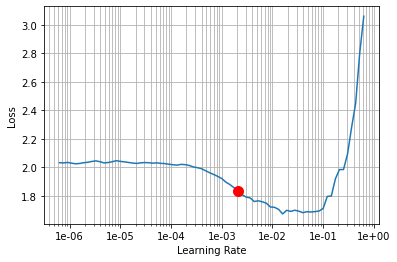

In [ ]:
lr_find = LrFinder(model, optimizer, loss_fn)
lr_find.range_test(train_ds)
lr_find.plot_lrs(suggestion=True, show_grid=True)

In [ ]:
base_lr = 1e-03

### 3.1.2. Treinando

In [ ]:
model.compile(optimizer=Adam(learning_rate= base_lr), 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=metricasEscolhidas)

In [ ]:
history = model.fit(train_ds,
                    class_weight = weights_train_dict,
                    steps_per_epoch = train_steps,
                    epochs=first_epoch,
                    validation_data=val_ds,
                    validation_steps = val_steps)

Epoch 1/30
626/626 [==============================] - 1403s 2s/step - loss: 7.6747 - acc: 0.3296 - auc: 0.7633 - precision: 0.3732 - recall: 0.1274 - val_loss: 1.5696 - val_acc: 0.3938 - val_auc: 0.7887 - val_precision: 0.4444 - val_recall: 0.1865
Epoch 2/30
626/626 [==============================] - 74s 117ms/step - loss: 6.5179 - acc: 0.4222 - auc: 0.8211 - precision: 0.5015 - recall: 0.2367 - val_loss: 1.5982 - val_acc: 0.3679 - val_auc: 0.7976 - val_precision: 0.4444 - val_recall: 0.2487
Epoch 3/30
626/626 [==============================] - 74s 117ms/step - loss: 6.2053 - acc: 0.4477 - auc: 0.8353 - precision: 0.5344 - recall: 0.2833 - val_loss: 1.2207 - val_acc: 0.5389 - val_auc: 0.8758 - val_precision: 0.6569 - val_recall: 0.3472
Epoch 4/30
626/626 [==============================] - 74s 117ms/step - loss: 5.9479 - acc: 0.4630 - auc: 0.8479 - precision: 0.5482 - recall: 0.3121 - val_loss: 1.3641 - val_acc: 0.4715 - val_auc: 0.8472 - val_precision: 0.5702 - val_recall: 0.3368
Epoch

### 3.1.3. Avaliando o treinamento do modelo

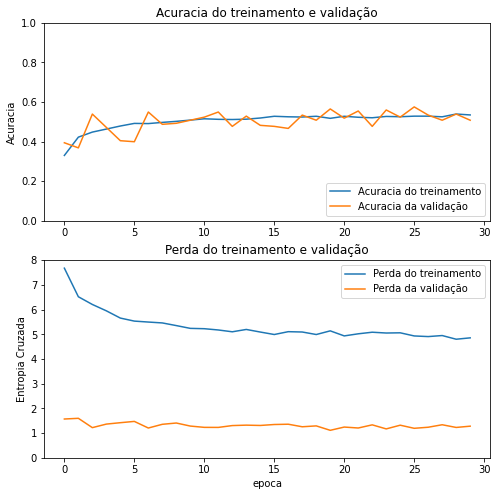

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Acuracia do treinamento')
plt.plot(val_acc, label='Acuracia da validação')
plt.legend(loc='lower right')
plt.ylabel('Acuracia')
plt.ylim([0,1])
plt.title('Acuracia do treinamento e validação')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Perda do treinamento')
plt.plot(val_loss, label='Perda da validação')
plt.legend(loc='upper right')
plt.ylabel('Entropia Cruzada')
plt.ylim([0,8])
plt.title('Perda do treinamento e validação')
plt.xlabel('epoca')
plt.show()

## 3.2. Criando o modelo: Segundo Momento

In [ ]:
modelBase.trainable = True # Descongelando os pesos do modelo base para o treinamento

In [ ]:
model.summary()

Model: "EfficientNetB2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 448, 448, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, 448, 448, 3)       0         
_________________________________________________________________
efficientnetb2 (Functional)  (None, 14, 14, 1408)      7768569   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1408)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 9863      
Total params: 7,778,432
Trainable params: 7,710,857
Non-trainable params: 67,575
_____________________________________

### 3.2.1. Buscando a taxa de aprendizado: LRFinder 2

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.CategoricalCrossentropy()

Finding best initial lr over 100 steps


  0%|          | 0/100 [00:00<?, ?it/s]

LR Finder is complete, type {LrFinder}.plot_lrs() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.20E-04


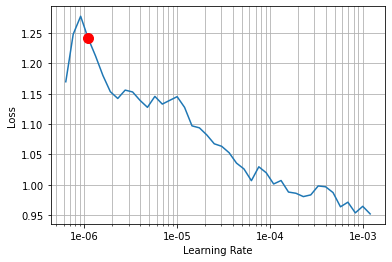

In [ ]:
lr_find = LrFinder(model, optimizer, loss_fn)
lr_find.range_test(train_ds)
lr_find.plot_lrs(suggestion=True, show_grid=True)

In [ ]:
base_lr = 1e-6
max_lr = 1e-5

### 3.2.2. Definindo os Callbacks

#### 3.2.2.1. CyclicalLR

In [ ]:
step_size = train_steps
clr = CyclicalLR(max_lr=max_lr, 
                 base_lr=base_lr, 
                 step_size=step_size, 
                 cyclical_momentum=False)

#### 3.2.2.2. Checkpoint

In [ ]:
checkpoint = ModelCheckpoint(save_dir + str(nomeDoModelo) + '.h5',
                                                  monitor='val_auc', verbose=1,
                                                  save_best_only=True, mode='max')

#### 3.2.2.3. Earlystopping

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss',
                              verbose=1, mode='min', 
                              restore_best_weights=False,
                              patience=15)

In [ ]:
# Lista contendo todos os callbacks
callbacks_list = [checkpoint, earlystopping, clr]

### 3.2.3. Treinando

In [ ]:
model.compile(optimizer=Adam(learning_rate=base_lr), 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=metricasEscolhidas)

In [ ]:
history_fine = model.fit(train_ds,
                    class_weight = weights_train_dict,
                    steps_per_epoch = train_steps,
                    epochs=second_epoch,
                    initial_epoch=history.epoch[-1],
                    validation_data=val_ds,
                    validation_steps = val_steps,
                    callbacks = callbacks_list)

Epoch 30/100
626/626 [==============================] - 463s 723ms/step - loss: 4.6060 - acc: 0.5500 - auc: 0.8924 - precision: 0.6133 - recall: 0.4686 - val_loss: 1.1689 - val_acc: 0.5389 - val_auc: 0.8972 - val_precision: 0.6101 - val_recall: 0.5026

Epoch 00030: val_auc improved from -inf to 0.89723, saving model to /content/drive/MyDrive/TCC-Melo/Kaggle/Modelos_checkPoint_val_test/EfficientNetB2.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 31/100
626/626 [==============================] - 446s 713ms/step - loss: 4.1976 - acc: 0.5803 - auc: 0.9090 - precision: 0.6329 - recall: 0.5085 - val_loss: 1.1347 - val_acc: 0.5389 - val_auc: 0.9035 - val_precision: 0.5926 - val_recall: 0.4974

Epoch 00031: val_auc improved from 0.89723 to 0.90352, saving model to /content/drive/MyDrive/TCC-Melo/Kaggle/Modelos_checkPoint_val_test/EfficientNetB2.h5
Epoch 32/100
626/626 [==============================] - 451s 720ms/step - loss: 3.8209 - acc: 0.6011 - auc: 0.9168 - precision: 0.6512 - recall: 0.5380 - val_loss: 1.0163 - val_acc: 0.6010 - val_auc: 0.9200 - val_precision: 0.6374 - val_recall: 0.5648

Epoch 00032: val_auc improved from 0.90352 to 0.92004, saving model to /content/drive/MyDrive/TCC-Melo/Kaggle/Modelos_checkPoint_val_test/EfficientNetB2.h5
Epoch 33/100
626/626 [==============================] - 451s 721ms/step - loss: 3.6429 - acc: 0.6153 - auc: 0.9239 - precision: 0.6574 - recall: 0.5610 - val_loss: 1.0861 - val_acc: 

### 3.2.4. Avaliando o treinamento do modelo

In [ ]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

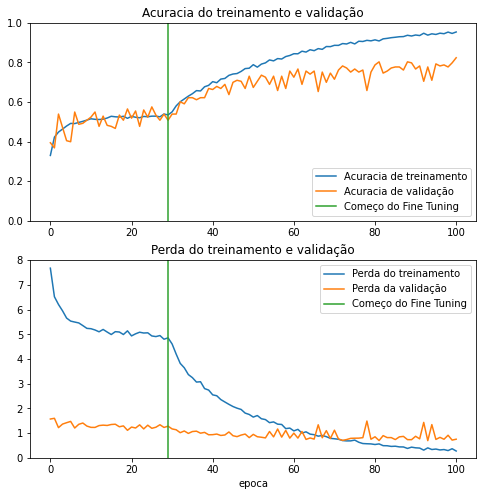

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Acuracia de treinamento')
plt.plot(val_acc, label='Acuracia de validação')
plt.ylim([0, 1])
plt.plot([first_epoch-1,first_epoch-1],
          plt.ylim(), label='Começo do Fine Tuning')
plt.legend(loc='lower right')
plt.title('Acuracia do treinamento e validação')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Perda do treinamento')
plt.plot(val_loss, label='Perda da validação')
plt.ylim([0, 8])
plt.plot([first_epoch-1,first_epoch-1],
         plt.ylim(), label='Começo do Fine Tuning')
plt.legend(loc='upper right')
plt.title('Perda do treinamento e validação')
plt.xlabel('epoca')
plt.show()

#### 3.2.4.1. Verificando CLR

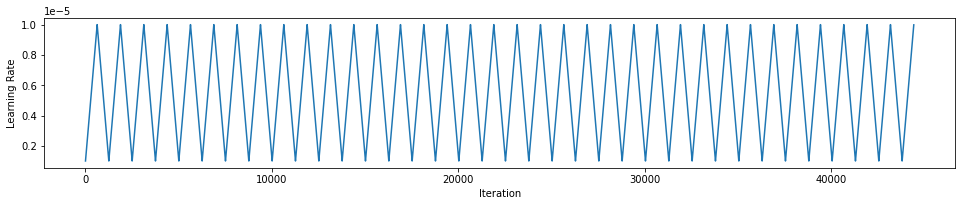

In [ ]:
clr.plot_lr((14, 3.5))

# 4. Avaliando o modelo - Validação

In [24]:
#model.load_weights(save_dir + str(nomeDoModelo) + '.h5')
model = tf.keras.models.load_model(save_dir + str(nomeDoModelo) + '.h5')

In [25]:
model.evaluate(val_ds)

13/13 [==============================] - 40s 2s/step - loss: 0.8442 - acc: 0.8031 - auc: 0.9593 - precision: 0.8118 - recall: 0.7824


[0.8442480564117432,
 0.803108811378479,
 0.9593479633331299,
 0.8118279576301575,
 0.7823834419250488]

## 4.1. Realizando as previsões

In [26]:
# Obtendo a tabela verdade 
true_categories = tf.concat([y for x, y in val_ds], axis=0)
true_categories  = tf.argmax(true_categories , axis=1)

In [27]:
# Realizando as previsões
predictions = model.predict(val_ds, verbose=1) 

# salvando as previsões para o ensemble
df_predict = pd.DataFrame(data=predictions, columns=classes)
df_predict.to_csv(save_dir_previsoes_val + f'{nomeDoModelo}_val.csv', index=False)

# Realizando o processo de maximizar os resultados
y_pred = tf.argmax(predictions, axis=1)

13/13 [==============================] - 3s 95ms/step


In [28]:
# Transformando para numpy e realizar o processo de dummy
true_categories_np = true_categories.numpy()
y_pred_np = y_pred.numpy()

ohe = OneHotEncoder(sparse=False)

true_categories_np_ohe = ohe.fit_transform(true_categories_np.reshape(-1, 1))
y_pred_np_ohe = ohe.transform(y_pred_np.reshape(-1, 1))

## 4.3. Metricas de avaliação


### 4.3.1. Curva ROC-AUC


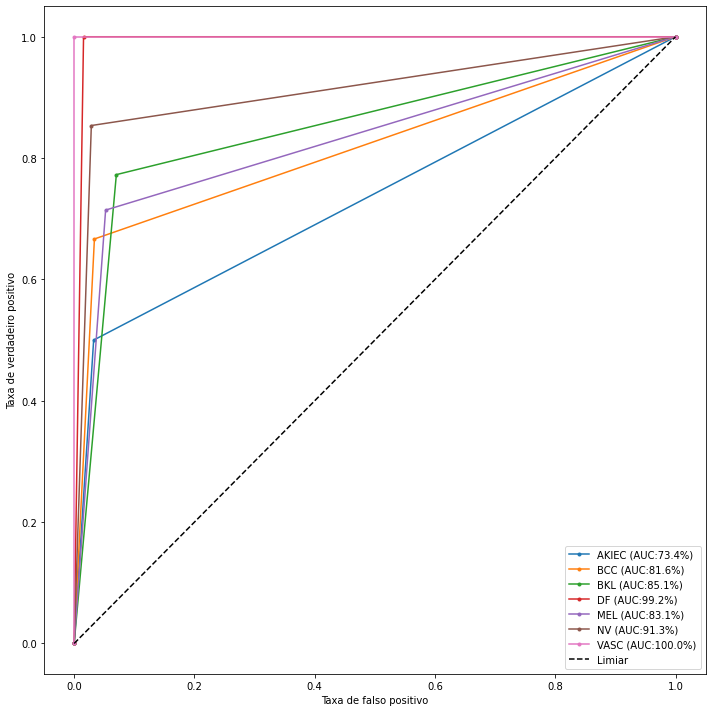

In [29]:
# Curva ROC-AUC
fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))

for i, classe in enumerate(classes):

    tpr, fpr, thresh = roc_curve(y_true=true_categories_np_ohe[:, i], y_score=y_pred_np_ohe[:, i])

    auc_roc = roc_auc_score(y_true=true_categories_np_ohe[:, i], y_score=y_pred_np_ohe[:, i])

    ax1.plot(tpr, fpr, marker='.', label=f'{classe} (AUC:{auc_roc:2.1%})')

ax1.plot([0, 1], [0, 1], linestyle='--', label='Limiar', color='k')
ax1.legend()
plt.xlabel("Taxa de falso positivo")
plt.ylabel("Taxa de verdadeiro positivo")
plt.tight_layout()
plt.savefig(save_dir_plot + f'{nomeDoModelo}_ROC-AUC.png')

### 4.3.2. Curva Precisão-Revocação


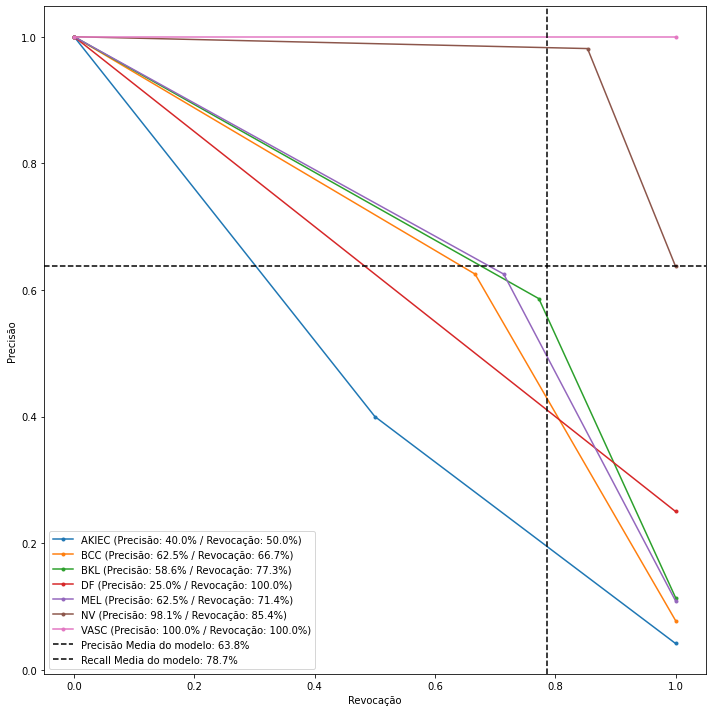

In [30]:
# Curva Precisão-Recall

fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))
precision_med = []
recall_med = []
no_skill = len(true_categories[true_categories==1]) / len(true_categories)

for i, classe in enumerate(classes):

    precision, recall, thresh = precision_recall_curve(true_categories_np_ohe[:, i], y_pred_np_ohe[:, i])
    precision_med.append(precision_score(true_categories_np_ohe[:, i], y_pred_np_ohe[:, i]))
    recall_med.append(recall_score(true_categories_np_ohe[:, i], y_pred_np_ohe[:, i]))
    ax1.plot(recall, precision, marker='.', label=f'{classe} (Precisão: {precision_med[i]:2.1%} / Revocação: {recall_med[i]:2.1%})')


precision = sum(precision_med)/len(precision_med)
recall = sum(recall_med)/len(recall_med)
ax1.axhline(y=precision, linestyle='--', color='k', label=f'Precisão Media do modelo: {precision:2.1%}')
ax1.axvline(x=recall, linestyle='--', color='k', label=f'Recall Media do modelo: {recall:2.1%}')
ax1.legend(loc="best")
plt.xlabel("Revocação")
plt.ylabel("Precisão")
plt.tight_layout()
plt.savefig(save_dir_plot + f'{nomeDoModelo}_Prec_Recall.png')

### 4.3.3. Predições


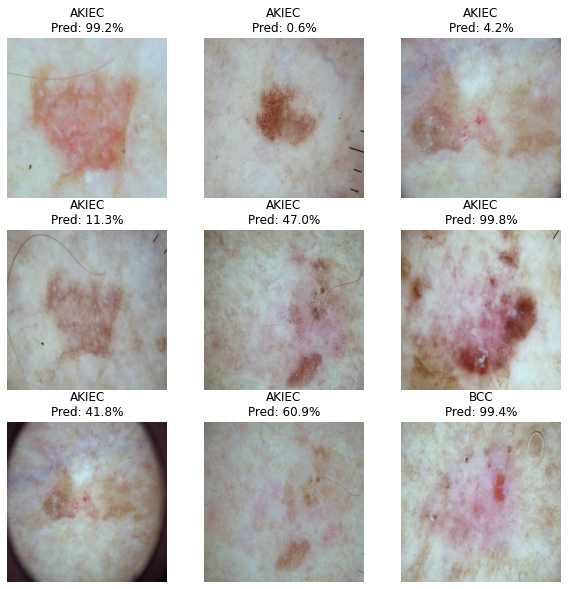

In [31]:
plt.figure(figsize=(10, 10))

for images, labels in val_ds.take(1):
  labels = np.argmax(labels, axis=1)
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    c_title = f'{classes[labels[i]]}\nPred: {100*predictions[i, true_categories[i]]:2.1f}%'
    plt.title(c_title)
    plt.axis("off")

plt.savefig(save_dir_plot + f'{nomeDoModelo}_predito.png')

### 4.3.4. Quadro de metricas

In [32]:
print(classification_report(true_categories , y_pred, target_names=classes))

              precision    recall  f1-score   support

       AKIEC       0.40      0.50      0.44         8
         BCC       0.62      0.67      0.65        15
         BKL       0.59      0.77      0.67        22
          DF       0.25      1.00      0.40         1
         MEL       0.62      0.71      0.67        21
          NV       0.98      0.85      0.91       123
        VASC       1.00      1.00      1.00         3

    accuracy                           0.80       193
   macro avg       0.64      0.79      0.68       193
weighted avg       0.84      0.80      0.82       193



### 4.3.5. Matriz de confusão

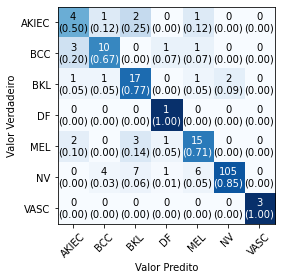

In [33]:
cm = confusion_matrix(true_categories , y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True, 
                                class_names=classes)
plt.xlabel("Valor Predito")
plt.ylabel("Valor Verdadeiro")
plt.savefig(save_dir_plot + f'{nomeDoModelo}_matConf.png')

### 4.3.6. Acurácia balanceada

In [34]:
bAcc= sklearn.metrics.balanced_accuracy_score(true_categories, y_pred)
print(f'Acurácia balanceada: {bAcc*100:.6f}%')

Acurácia balanceada: 78.676260%


# 5. Avaliando o modelo - Teste

In [35]:
model.load_weights(save_dir + str(nomeDoModelo) + '.h5')
#model = tf.keras.models.load_model(save_dir + str(nomeDoModelo) + '.h5'')

In [ ]:
# Realizando a previsão
predictions = model.predict(test_ds, verbose=1)

53/95 [===============>..............] - ETA: 1:19

In [ ]:
# Pegando nome dos arquivos

rtxt = re.compile(r'(.*?)\.jpg')
files = (rtxt.match(file) for file in os.listdir(test_path))
files = [match.group(1) for match in files if match]
files = sorted(files)

## 5.1. Realizando as previsões

In [ ]:
df_predict = pd.DataFrame(data=predictions,index=files ,columns=classes).reset_index().rename(columns={'index':'image'})
df_predict.to_csv(save_dir_previsoes_test + f'{nomeDoModelo}_test.csv', index=False)